# Applied practical from Huanfa to my data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# feature importance
import rfpimp

# xgboost
import xgboost
from xgboost import XGBRegressor

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [2]:
# check the library version before we start
print("xgboost version:{}".format(xgboost.__version__))
print("sklearn version:{}".format(sklearn.__version__))

xgboost version:1.7.3
sklearn version:1.3.2


## Data Loading and Exploration

In [3]:

#set file paths

path_r9_input = '//Users/sophieayling/Library/CloudStorage/GoogleDrive-sophie2ayling@gmail.com/My Drive/PhD/08_Fieldwork/08_Data/R9_data/stata_input/'
path_census_input = '/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/preprocessed/census/5_perc/'
path_census_output = '/Users/sophieayling/Library/CloudStorage/GoogleDrive-sophie2ayling@gmail.com/My Drive/PhD/08_Fieldwork/08_Data/R9_data/plots/starplots/'

r9_data=path_r9_input+"r9_ivqselect_feb2023_v3_newVars.dta"
ipums_5p=path_census_input+"ipums_5p_2012_preprocessed.dta"
r9 = pd.read_stata(r9_data)
r9 = r9[['hhmem_key', 'hhid', 'gender_9', 'ses_5', 'age_9',  'site_type', 'occupation', 'occ4', 'school_enrolled', 'tot_contacts_yest','all_home_yest',  'all_work_yest', 'all_school_yest', 'all_com_yest', 'all_trans_yest', 'all_ent_yest', 'work_bubble', 'school_bubble', 'comm_bubble', 'transit_bubble']]


In [4]:
r9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9418 entries, 0 to 9417
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   hhmem_key          9418 non-null   object  
 1   hhid               9418 non-null   object  
 2   gender_9           9418 non-null   category
 3   ses_5              9358 non-null   category
 4   age_9              9418 non-null   int16   
 5   site_type          9418 non-null   category
 6   occupation         9418 non-null   category
 7   occ4               9418 non-null   category
 8   school_enrolled    7778 non-null   category
 9   tot_contacts_yest  9190 non-null   float32 
 10  all_home_yest      8966 non-null   float32 
 11  all_work_yest      1806 non-null   float32 
 12  all_school_yest    721 non-null    float32 
 13  all_com_yest       2348 non-null   float32 
 14  all_trans_yest     821 non-null    float32 
 15  all_ent_yest       198 non-null    float32 
 16  work_b

### Converting categorical variables

Before undertaking regression, we need to handle categorical variables, as ML models usually can't deal with *strings* or *categories*.

While there are other ways of handling categorical variables in machine learning, we will stick to one-hot encoding, as it is easy to understand and appropriate for medium-size datasets (sample size <10000).

First, we need to convert categorical variables into dummy/indicator variables, using `One-Hot Encoding`.

In [5]:
#clean up the variables before putting them in the model
r9_filtered=r9[r9['all_work_yest'].notnull()]

#covariates
X= r9_filtered[['gender_9', 'ses_5', 'age_9', 'site_type', 'occ4', 'school_enrolled']]

# convert the categorical variables to dummies using one-hot encoding 
r9_filtered_numeric = pd.get_dummies(X)

# check out the new dataframe 
r9_filtered_numeric.info()



<class 'pandas.core.frame.DataFrame'>
Index: 1806 entries, 7 to 9412
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   age_9                                        1806 non-null   int16
 1   gender_9_1. Male                             1806 non-null   bool 
 2   gender_9_2. Female                           1806 non-null   bool 
 3   ses_5_0. Poorest                             1806 non-null   bool 
 4   ses_5_1. 2nd poorest                         1806 non-null   bool 
 5   ses_5_2. 3rd poorest                         1806 non-null   bool 
 6   ses_5_3. 4th poorest                         1806 non-null   bool 
 7   ses_5_4. Least poor                          1806 non-null   bool 
 8   site_type_1. subsistence farming             1806 non-null   bool 
 9   site_type_2. roadside trading settlement     1806 non-null   bool 
 10  site_type_3. agri estate     

In [6]:
# dependent variable needs to be converted to a 1D array 
y_array= np.array(r9_filtered[['all_work_yest']]) # this must be the same as doing all_work_yest.values
y= y_array.ravel()
print(y)

y=r9_filtered.all_work_yest


[ 2. 10.  2. ... 10. 20.  2.]


Remember that, a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables. The level that is left out becomes the reference level, and this is important for interpreting the regression model.

Here we manually choose the reference level for each categorical variable and exclude them from the DataFrame. You can change the reference levels if you want.

In [7]:
# drop the reference categories from the DF (as per Huanfa's tutorial https://github.com/huanfachen/DSSS/blob/main/Week_2/Practical-02_SOLUTION.ipynb)

columns_to_drop = [1, 3, 8, 22, 28]
r9_final_ML= r9_filtered_numeric

# check final result 
r9_final_ML.info()

# reassign X covariates
X= r9_final_ML


<class 'pandas.core.frame.DataFrame'>
Index: 1806 entries, 7 to 9412
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   age_9                                        1806 non-null   int16
 1   gender_9_1. Male                             1806 non-null   bool 
 2   gender_9_2. Female                           1806 non-null   bool 
 3   ses_5_0. Poorest                             1806 non-null   bool 
 4   ses_5_1. 2nd poorest                         1806 non-null   bool 
 5   ses_5_2. 3rd poorest                         1806 non-null   bool 
 6   ses_5_3. 4th poorest                         1806 non-null   bool 
 7   ses_5_4. Least poor                          1806 non-null   bool 
 8   site_type_1. subsistence farming             1806 non-null   bool 
 9   site_type_2. roadside trading settlement     1806 non-null   bool 
 10  site_type_3. agri estate     

### Splitting data into random train and test subsets

By default, `train_test_split` will split the data according to a 75:25 split. Other proportions can be specified, check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for details.

Remember that the split should be random in order to avoid selection bias. Here, we set random_state=100 to guarantee reproducibility.

From the documentation:

The first argument of this function:

```
*arrays: sequence of indexables with same length / shape[0]
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
```

The output of this function:
```
splitting: list, length=2 * len(arrays)
List containing train-test split of inputs.
```

Here we input two dataframes (X and Y) and will get four outputs (train_x, test_x, train_y, test_y).

In [8]:
random_state_split = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Double check the rows and columns of the outputs.

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(X_train.index.identical(y_train.index))
print(X_test.index.identical(y_test.index))

(1444, 30)
(1444,)
(362, 30)
(362,)
True
True


In the regression models, we will use the training set to train the model and select hyperparameters. The testing set is only used to report the performance of the finalised model.

## Building a CART

We will build a CART to predict contact numbers, following two steps:

1. Tune the hyperparameters of max_depth and min_samples_split using cross validation;
2. Train a final model based on the tuned hyperparameters and evaluate the model performance.

Here, we focus on two hyperparameters that control the stopping criteria of the model training: max_depth and min_samples_split.

*max_depth* refers to the maximal depth (or height) of a tree. In sklearn, if this value is not specified, the nodes would be expanded until all leaves contain samples of the same y value or until all leaves contain less than min_samples_split samples.

Intuition about max_depth: the larger the maximum tree depth, the better fitness of the model on the training data and thus the higher possibility of overfitting.

Ideally, we want the maximum tree height to be neither too small or too large.

The documentation is as follows:

```
max_depth: int, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
```

*min_samples_split* refers to the minimum number of samples required to split a node. If a node contains less samples than min_samples_split, this node becomes a leaf node and would not split.

The smaller value of min_samples_split, the better fitness of the model and thus the higher possibility of overfitting.

The documentation is as follows (note that the value can be either integer or float, but the meaning is different)

```
min_samples_split: int or float, default=2
The minimum number of samples required to split an internal node:

If int, then consider min_samples_split as the minimum number.

If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
```

### Tuning the hyperparameters using cross validation

We will use ```GridSearchCV``` to find the optimal combination of max_depth and min_samples_split. 

Note that in grid search, all combinations of hyperparameters will be tested and compared. In this case, 25 (5*5) different combinations of hyperparameters will be tested.

**One question - how to determine the potential values of max_depth and min_samples_split?**

For min_samples_split, as it is a positive integer value and the default value is 2, we can set the range as [2,4,6,8,10].

For max_depth, we can build a decision tree using default settings and check the tree depth, then choose the range around this tree depth.

The code below shows that the tree depth of a CART with default settings is 25, so we can set the range as [10,20,30,40,50].

In [10]:
# a CART using default settings
cart_default = DecisionTreeRegressor(random_state=0)
cart_default.fit(X_train, y_train)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 28


In [11]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(dt, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 10}
The best score is: 
-0.362932108873309


### Training the final CART

In [12]:
dt_final = DecisionTreeRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
dt_final.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=10000)

In [13]:
print("R2 on the training data:")
print(dt_final.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(dt_final.score(X=X_test, y=y_test))

R2 on the training data:
0.31964919892846066
R2 on the testing data:
-0.2638656616719717


It looks like the R2 on the testing data is much lower than that on the training data. This indicates the overfitting problem, meaning that the model fits very well to the training data but doesn't generalise well to unseen data.

In [14]:
print("RMSE on the training data:")
print(mean_squared_error(y_train, dt_final.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, dt_final.predict(X_test), squared=False))

RMSE on the training data:
25.503837833303596
RMSE on the testing data:
30.98504121267847


The RMSE is in the same unit of the y variable (contacts yesterday). On the testing data, on average, the model's prediction deviates from the number of contacts by 30.

If you want to know the relative error, you can compute the normalised RMSE by dividing the mean true value, as follows:

In [15]:
print("Normalised RMSE on the training data:")
print(mean_squared_error(y_train, dt_final.predict(X_train), squared=False)/np.mean(y_train))
print("Normalised RMSE on the testing data:")
print(mean_squared_error(y_test, dt_final.predict(X_test), squared=False)/np.mean(y_test))

Normalised RMSE on the training data:
1.377193914671362
Normalised RMSE on the testing data:
1.6286604728747767


## Interpreting the CART

In [16]:
# some attributes of the tree
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))

Tree depth:10
Number of leaves:105


There are different ways to inspect and interpret the CART. 

One way is to visualise the whole tree and check each node and split. However, this is not easy for a tree with 10 layers and over 100 leaves.

Another way is to check the relative importance of each feature, for example, using the permutation feature importance.

To do this, we will use the **rfpimp** package. 

**rfpimp** is short for random forest permutation importance. It is a library that provides feature importances, based upon the permutation importance strategy, for general scikit-learn models and implementations specifically for random forest out-of-bag scores. Built by Terence Parr and Kerem Turgutlu.


We will use the **rfpimp.importances** function to compute the feature importance. According to [its documentation](https://github.com/parrt/random-forest-importances/blob/master/src/rfpimp.py):

```
Compute permutation feature importances for scikit-learn models using a validation set.
Given a Classifier or Regressor in model and validation X and y data, return a data frame with columns.
Feature and Importance sorted in reverse order by importance.
The validation data is needed to compute model performance measures (accuracy or R^2). The model is not retrained.
```

So the importance of a feature x is defined as the difference of the R^2 model score (computed by **dt_final.score()**) after shuffling x and without shuffling x.

The feature importance is mostly positive or a negative value very close to zero, as shuffling a feature is not expected to greatly improve the model performance.

The feature importance is usually used to compare the relative importance of features. It is not recommended to interpret the absolute value of this importance.

In [17]:
# the importances function returns a dataframe of two columns, Feature and Importance, and the features are ranked from the most important to the least.
imp = rfpimp.importances(dt_final, X_test, y_test)
print(imp)

                                                                          Importance
Feature                                                                             
ses_5_3. 4th poorest                                                          0.0813
occ4_8. informal-petty trade                                                  0.0680
occ4_4. education                                                             0.0560
site_type_4. commercial centre within rural                                   0.0465
gender_9_1. Male                                                              0.0293
ses_5_2. 3rd poorest                                                          0.0242
site_type_3. agri estate                                                      0.0066
occ4_14. transport sector                                                     0.0055
occ4_11. unemployed excl. ag                                                  0.0052
occ4_9. subsistence ag                                           

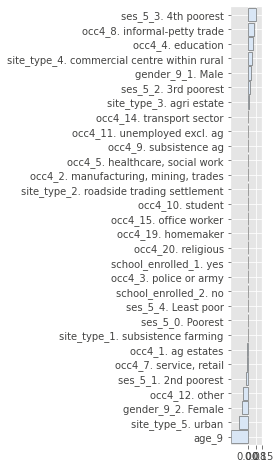

In [18]:
## Here is a barplot of the feature importance
viz = rfpimp.plot_importances(imp)
viz.view()

The feature importance above shows that the most important features are **commercial centre (site type)**, **petty trade (occupation)**, and **3rd poorest (wealth quintile)**.

Later on, we will compare the feature importance of diffferent models - CART, RF, and GBDT.

## Building and interpreting a random forest

In this part, we will use the random forest method to predict the daily bicycle rental. We will follow a simple workflow as CART: tune the hyperparameters and then train the final model.

RF has two groups of hyperparameters:

1. The hyperparameters of decision trees, such as max_depth, min_samples_split;
2. The configurations of RF, such as the number of trees (called **n_estimators**). By default, **n_estimators** is set as 100. Some intuition is that the larger n_estimators, the more stable the model performance and the longer computing time. This is because the computing time is a linear function of the number of trees.

The default value of 100 trees is good for most applications, so we don't tune this hyperparameter here.

As with CART, we will focus on the tuning of max_depth and min_samples_split.



In [19]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 10}
The best score is: 
-0.00987531193706952


Train the final RF.

In [20]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=10000)

In [21]:
print("R2 on the training data:")
print(rf_final.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(rf_final.score(X=X_test, y=y_test))

R2 on the training data:
0.33181023393746645
R2 on the testing data:
-0.013173370107702809


So - what do you think about the comparison of R2 on the training and testing data?

The R2 on the testing data of RF is still negative, but better than the CART so it's a slight improvement

In [22]:
print("RMSE on the training data:")
print(mean_squared_error(y_train, rf_final.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, rf_final.predict(X_test), squared=False))

RMSE on the training data:
25.27487392165195
RMSE on the testing data:
27.742366452086205


As with CART, it is not useful to visualise the trees in a random forest.

Calculate and plot the feature importance of the RF model.

The fact that the order of features changes indicates that these features aren't great at predicting the number of contacts at all

                                                                          Importance
Feature                                                                             
occ4_4. education                                                             0.0981
site_type_4. commercial centre within rural                                   0.0717
ses_5_1. 2nd poorest                                                          0.0345
occ4_14. transport sector                                                     0.0341
occ4_8. informal-petty trade                                                  0.0114
ses_5_3. 4th poorest                                                          0.0069
occ4_15. office worker                                                        0.0050
occ4_19. homemaker                                                            0.0045
ses_5_0. Poorest                                                              0.0025
occ4_9. subsistence ag                                           

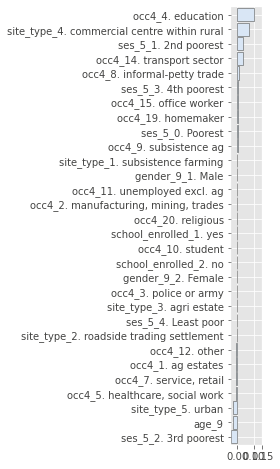

In [23]:
imp = rfpimp.importances(rf_final, X_test, y_test)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

## Building and interpreting a XGBoost

In this part, we will use the XGBoost method to predict contacts the previous day. We will follow a simple workflow as CART and RF: tune the hyperparameters and then train the final model.

XGBoost is not part of the sklearn library but a separate library. It provides the sklearn API so that we can use XGboost in the same way as RandomForestRegressor of sklearn.

XGBoost has two groups of hyperparameters:

1. The hyperparameters of decision trees, such as max_depth, min_samples_split;
2. The configurations of XGBoost, such as the number of trees (called **n_estimators**) and regularisation hyperparameters.

Here are a list of potentially important hyperparameters for XGBoost, recommended by [this post](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663):

1. `max_depth`: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit. The value must be an integer greater than 0. Default is 6.

1. `learning_rate`: The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum. The value must be between 0 and 1. Default is 0.3.

1. `n_estimators`: The number of trees in the ensemble. Equivalent to the number of boosting rounds. The value must be an integer greater than 0. Default is 100.

1. `colsample_bytree`: Represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting.
The value must be between 0 and 1. Default is 1.

1. `subsample`: Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting.
The value must be between 0 and 1. Default is 1.

1. `alpha (reg_alpha)`: L1 regularization on the weights (Lasso Regression). When working with a large number of features, it might improve speed performances. It can be any integer. Default is 0.

1. `lambda (reg_lambda)`: L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting. It can be any integer. Default is 1.

1. `gamma`: Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. The higher Gamma is, the higher the regularization. It can be any integer. Default is 0.

The last three hyperparameters - alpha, lambda, and gamma - are related to the regularization of the model. In machine learning, regularization is a number of techniques to reduce the model complexity and the chances of overfitting.

If you want to know more about these hyperparameters, you can read [the XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html).

Here, we will focus on the tuning of max_depth and n_estimators.

One note is that this grid search may take several minutes, which is longer than CART or random forest.

In [24]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[50,100,150,200,250]}

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.best_score_)

The best parameter value is: 
{'max_depth': 10, 'n_estimators': 50}
The best score is: 
-0.916060356905535


Train the final XGBoost.

In [25]:
xgb_final = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
xgb_final.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=125, ...)

In [26]:
print("R2 on the training data:")
print(xgb_final.score(X=X_train, y=y_train))
print("R2 on the testing data:")
print(xgb_final.score(X=X_test, y=y_test))

R2 on the training data:
0.818243576576089
R2 on the testing data:
-0.31118121225748174


So - what do you think about the comparison of R2 on the training and testing data?

The R2 on the testing data of XGBoost is lower than both CART and RF. 

In [27]:
print("RMSE on the training data:")
print(mean_squared_error(y_train, xgb_final.predict(X_train), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test, xgb_final.predict(X_test), squared=False))

RMSE on the training data:
13.182081
RMSE on the testing data:
31.559708


As with CART, it is not useful to visualise the trees in a random forest.

Calculate and plot the feature importance of the XGboost model.

Again the ordering is different from the RF and the CART models, though it is more similar to the CART model.


                                                                          Importance
Feature                                                                             
occ4_14. transport sector                                                     0.1543
site_type_4. commercial centre within rural                                   0.1132
occ4_4. education                                                             0.0726
gender_9_1. Male                                                              0.0478
occ4_7. service, retail                                                       0.0343
occ4_11. unemployed excl. ag                                                  0.0126
ses_5_0. Poorest                                                              0.0084
ses_5_3. 4th poorest                                                          0.0033
occ4_9. subsistence ag                                                        0.0012
occ4_10. student                                                 

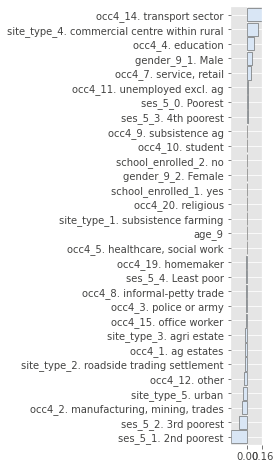

In [28]:
imp = rfpimp.importances(xgb_final, X_test, y_test) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

## Comparing three models

we will collate and compare the model performance of the three models.

In [29]:
# create a list of models
list_name_models = ['CART', 'RF', 'XGBoost']
# use the models from above
list_reg_models = [dt_final, rf_final, xgb_final]

dict_models = dict()

for name, model in zip(list_name_models, list_reg_models):
    dict_models[name] = [model.score(X_train, y_train), model.score(X_test, y_test), model.score(X_train, y_train) - model.score(X_test, y_test)]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
df_models
# you can then export df_models as a csv file and use it in MS Excel or Word
# df_models.to_csv(...)

,R2_train_data,R2_test_data,R2_diff
CART,0.3196,-0.2639,0.5835
RF,0.3318,-0.0132,0.3450
XGBoost,0.8182,-0.3112,1.1294


The result shows that XGBoost has the highest R2 for the training data but the lowest for the test data. The one that is less subject to overfitting would be the one with the least difference between the test and train R2 so RF. Still the R squared is so low! The difference is great also for CART...but I need to find out why this model is so terrible. 

***

what it said on the original tutorial: 


The above result shows that the random forest model has a higher R2 on the testing data than CART and XGBoost, as well as a smaller R2 difference between training and testing data. 

This indicates that the random forest model is less subject to the overfitting issue and has a better generalisation.

The XGBoost also has a less extent of overfitting than CART. 

For this reason, it is uncommon to use CART to directly make predictions. Rather, CART is used to construct RF or GBDT.

## Summary

Contrary to the original workshop data, this doesn't show particularly good results for any of the three models. The feature importance is inconsistent, and I can't tell if XG boost is really better because of the difference between the r2 on test and training. 

***

In this workshop, we have used decision trees, random forest, and gradient boosting decision trees to make predictions for the number of contacts. 

We compare the model performance and the feature importance. Overall, the RF and GBDT models have better predictive performance and better generalisation than CART.

The trend of relative feature importance is consistent across the three models. The most important features are days since 2011, temperature, and humidity.

In the later weeks, we will demonstrate the use of these models for classification tasks and the scalability of these models for big data.

## References and recommendations:

1. Permutation importance: [this chapter](https://christophm.github.io/interpretable-ml-book/feature-importance.html) is recommended, which is part of the E-book 'Interpretable machine learning'.
1. [The documentation](https://xgboost.readthedocs.io/en/latest/parameter.html) of XGBoost hyperparameters (note that they use the term *parameters* in this webpage).
